<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/stac_gage_ew_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# !pip install dataretrieval
import glob
import os
from dataretrieval import nwis as nwis
from dataretrieval import wqp
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import datetime
from tqdm import tqdm
from scipy.stats import linregress

In [33]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Pair gage ids with effective width point ids

In [34]:
gage_list = ['06801000','06801000','06801000',
             '06800500','06800500','06800500',
             '06805500','06805500','06805500',
             '06800000','06800000','06800000',
             '06775900','06775900','06775900',
             '06620000','06620000','06620000']

points = [201625, # 06801000
          153085,
          201888,
          246043, # 06800500
          246016,
          246048,
          202726, # 06805500
          203066,
          202446,
          120725, # 06800000
          120445,
          120748,
          94011, # 06775900
          93932,
          94005,
          41913, # 06620000
          41900,
          41930]


gage_pts = pd.DataFrame({'gage_id': gage_list,
                         'iindex': points})

u_gage_list = []
for g in set(gage_list):
    u_gage_list.append(g)

gage_pts = pd.merge(gage_pts, gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250909.shp'), how='outer', on='iindex')[['gage_id', 'iindex', 'riv_length']]
gage_pts

,gage_id,iindex,riv_length
0,06620000,41900,140.711919
1,06620000,41913,142.907272
2,06620000,41930,86.932041
3,06775900,93932,96.207959
4,06775900,94005,140.444539
5,06775900,94011,72.135208
6,06800000,120445,76.595306
7,06800000,120725,148.276448
8,06800000,120748,64.253559
9,06801000,153085,2096.250518


Load in-situ widths from USGS

In [35]:
width_dfs = []
for gage in set(gage_list):
    url = f'https://api.waterdata.usgs.gov/samples-data/results/fullphyschem?mimeType=text%2Fcsv&monitoringLocationIdentifier=USGS-{gage}&characteristicGroup=Physical&characteristicUserSupplied=Width%20of%20stream'

    tempdf = pd.read_csv(url)

    # ws = tempdf[['Location_Identifier', 'Activity_StartDate', 'Result_Measure']]
    width_dfs.append(tempdf)

isw = pd.concat(width_dfs)

isw['site_no'] = isw.apply(lambda x: x['Location_Identifier'].split('-')[1], axis=1)
isw = isw.rename(columns={'Activity_StartDate': 'date', 'Result_Measure': 'width_ft'})
isw['date'] = isw.apply(lambda x: datetime.date(int(x['date'].split('-')[0]), int(x['date'].split('-')[1]), int(x['date'].split('-')[2])), axis=1)
isw['gage_width_m'] = isw.width_ft / 3.28
isw = isw[['date', 'gage_width_m', 'site_no']].set_index(['site_no', 'date'])
isw

gage_width_m
site_no  date                    
06800000 2010-01-13     14.024390
         2016-04-12     18.292683
         2021-02-26     20.121951
         2012-05-10     16.768293
         2022-06-13     18.902439
...                           ...
06801000 2022-07-13    396.341463
         2021-10-05      0.000000
         2021-03-15    408.536585
         2022-09-07    378.048780
         2021-03-15    408.536585

[1234 rows x 1 columns]

Discharge

In [36]:
sites = ['06620000', '06775900', '06800000', '06800500', '06801000', '06805500']

# first and last dates same as for in situ widths
start = str(isw.index.sortlevel(1)[0][0][1])
end = str(isw.index.sortlevel(1)[0][-1][1])

Q = nwis.get_record(sites, service='dv', start=start, end=end).reset_index()
Q['date'] = Q.datetime.dt.date
Q = Q[['site_no', 'date', '00060_Mean']]
Q['00060_Mean'] = Q['00060_Mean'] * (3.28 ** -3)
Q = Q.rename(columns={'00060_Mean': 'Q_cms'})
Q = Q.set_index(['site_no', 'date'])
Q

Q_cms
site_no  date                  
06620000 2007-11-19    3.967405
         2007-11-20    3.740696
         2007-11-21    3.485648
         2007-11-22    3.230601
         2007-11-23    2.862199
...                         ...
06805500 2025-08-30  123.556318
         2025-08-31  127.523723
         2025-09-01  181.367072
         2025-09-02  459.085402
         2025-09-03  385.405029

[38994 rows x 1 columns]

Join in-situ width and discharge to build rating curves

In [37]:
cotemporal_wQ = Q.join(isw, how='inner', on=['site_no', 'date'])
cotemporal_wQ = cotemporal_wQ.loc[cotemporal_wQ.gage_width_m != 0]
cotemporal_wQ['logw'] = np.log10(cotemporal_wQ.gage_width_m)
cotemporal_wQ['logQ'] = np.log10(cotemporal_wQ.Q_cms)
cotemporal_wQ

Q_cms  gage_width_m      logw      logQ
site_no  date                                                    
06620000 2011-08-22   11.392119     46.951220  1.671647  1.056605
         2011-10-12    6.206155     46.951220  1.671647  0.792823
         2012-01-30    3.825712     39.634146  1.598070  0.582712
         2012-03-30   17.173195     47.865854  1.680026  1.234851
         2012-06-22    4.279129     37.804878  1.577548  0.631355
...                         ...           ...       ...       ...
06805500 2025-07-16  250.229883    378.048780  2.577548  2.398339
         2025-07-16  250.229883    378.048780  2.577548  2.398339
         2025-07-16  250.229883    378.048780  2.577548  2.398339
         2025-08-12  253.347129    378.048780  2.577548  2.403716
         2025-08-27  121.856002    378.048780  2.577548  2.085847

[1219 rows x 4 columns]

Text(0.02, 0.5, 'Gage width (m)')

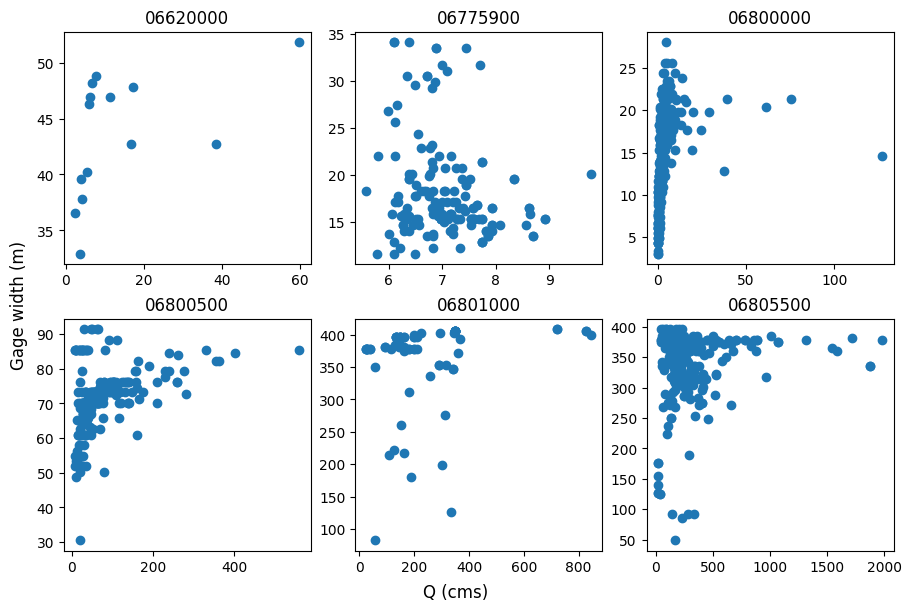

In [38]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)

p = 0
for sn, df in cotemporal_wQ.groupby('site_no'):
    ax = axs.flatten()[p]

    ax.scatter(df.Q_cms, df.gage_width_m)
    ax.set_title(sn)
    p += 1

fig.supxlabel('Q (cms)')
fig.supylabel('Gage width (m)')

Build power law rating curves with cotemporal gage w and Q

Text(0.5, 0.98, 'Power law w/Q rating curves')

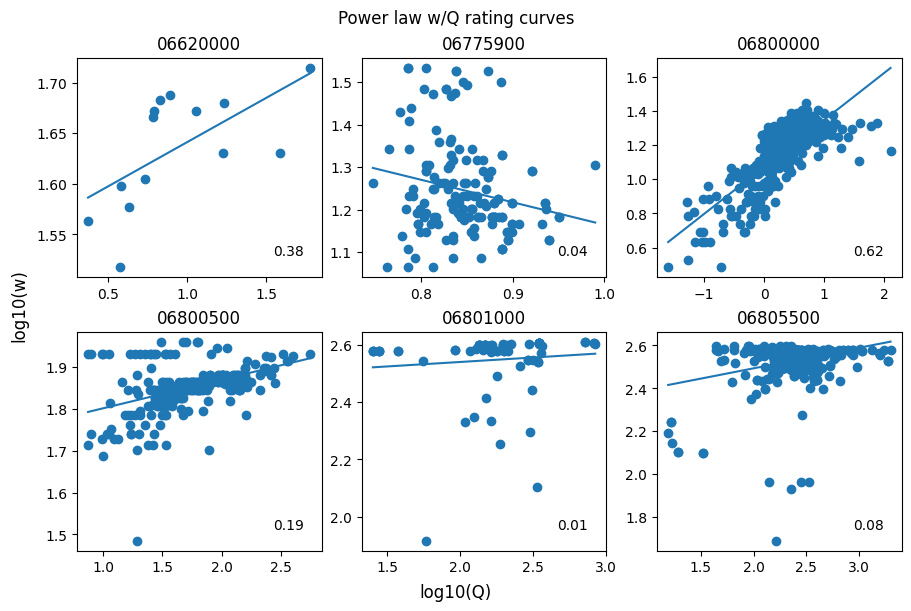

In [39]:
rc_slopes = []
rc_intercepts = []
r2s = []


fig, (axs) = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)
p = 0
for sn, df in cotemporal_wQ.groupby('site_no'):

    slope, intercept, r, pval, _ = linregress(df.logQ, df.logw)

    rc_slopes.append(slope)
    rc_intercepts.append(intercept)
    r2s.append(r ** 2)

    ax = axs.flatten()[p]
    ax.scatter(df.logQ, df.logw)
    ax.set_title(sn)
    rc_x = np.linspace(min(df.logQ), max(df.logQ))

    ax.plot(rc_x, rc_x * slope + intercept)
    ax.text(0.8, 0.1, f'{round(r ** 2, 2)}', transform=ax.transAxes)
    p += 1

fig.supxlabel('log10(Q)')
fig.supylabel('log10(w)')
fig.suptitle('Power law w/Q rating curves')

In [40]:
rating_curve_parms = pd.DataFrame({'site_no': u_gage_list, 'b': rc_slopes, 'loga': rc_intercepts, 'r2': r2s}).set_index('site_no')
rating_curve_parms['a'] = 10 ** rating_curve_parms.loga
rating_curve_parms

,b,loga,r2,a
site_no,,,,
06800000,0.087846,1.553382,0.383412,35.758761
06800500,-0.528364,1.692555,0.042450,49.266824
06775900,0.275466,1.072538,0.616820,11.817848
06620000,0.068638,1.732994,0.186642,54.074626
06805500,0.031141,2.477969,0.008993,300.585898
06801000,0.095966,2.301501,0.078646,200.216932


Estimate width from rating curve, full join with in-situ widths on date and gage id

In [41]:
def est_width(row, site_no):
    a = rating_curve_parms.loc[site_no, 'a']
    b = rating_curve_parms.loc[site_no, 'b']
    Q = row['Q_cms']

    return a * (Q ** b)

Q['rc_width_m'] = Q.apply(lambda row: est_width(row, row.name[0]), axis=1)
Q = Q.join(isw, how='outer', on=['site_no', 'date'])
Q

Q_cms  rc_width_m  gage_width_m
site_no  date                                            
06620000 2007-11-19    3.967405   59.439310           NaN
         2007-11-20    3.740696   59.199738           NaN
         2007-11-21    3.485648   58.913488           NaN
         2007-11-22    3.230601   58.607024           NaN
         2007-11-23    2.862199   58.121987           NaN
...                         ...         ...           ...
06805500 2025-08-30  123.556318  349.229742           NaN
         2025-08-31  127.523723  349.573630           NaN
         2025-09-01  181.367072  353.429025           NaN
         2025-09-02  459.085402  363.799788           NaN
         2025-09-03  385.405029  361.823254           NaN

[39189 rows x 3 columns]

Text(0.5, 0.98, 'Rating curve validation')

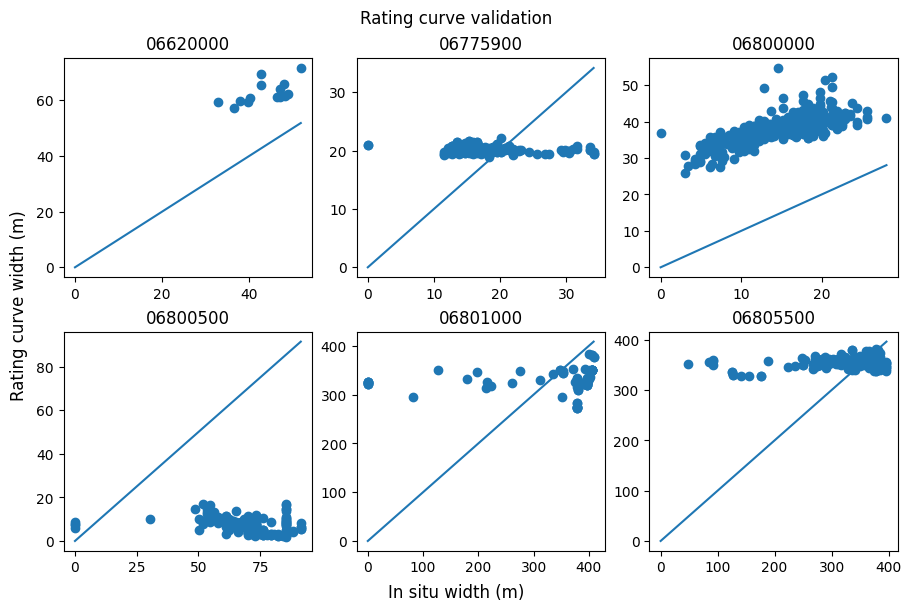

In [42]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)

p = 0
for sn, df in Q.groupby('site_no'):
    ax = axs.flatten()[p]

    ax.scatter(df.gage_width_m, df.rc_width_m)
    unity = np.linspace(0, (df.gage_width_m).max(skipna=True))
    ax.plot(unity, unity)
    ax.set_title(sn)
    p += 1

fig.supxlabel('In situ width (m)')
fig.supylabel('Rating curve width (m)')
fig.suptitle('Rating curve validation')

Load in effective width\
See stac_processing_download.ipynb

In [234]:
width_dfs = []
for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    width_dfs.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/gage_sites/gage_effwidths_{year}_20250911_nond.csv'))

allwidths = pd.concat(width_dfs)

allwidths['mgrs'] = allwidths.apply(lambda x: x['img_id'].split('_')[1], axis=1)
allwidths['date'] = allwidths.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
allwidths['version'] = allwidths.apply(lambda x: x['img_id'].split('_')[3], axis=1)

allwidths = allwidths.loc[allwidths.n_valid == allwidths.n_pixels]

allwidths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,mgrs,date,version
0,0,S2B_15TTF_20181229_0_L2A,246043,760,760,16,0,752,15TTF,2018-12-29,0
4,4,S2B_15TTF_20181229_0_L2A,246016,1892,1892,0,0,1792,15TTF,2018-12-29,0
6,6,S2B_15TTF_20181229_0_L2A,246048,1797,1797,22,11,1778,15TTF,2018-12-29,0
7,7,S2B_15TTF_20181229_0_L2A,201625,45736,45736,13965,22851,12294,15TTF,2018-12-29,0
8,8,S2B_14TPM_20181229_0_L2A,120725,164,164,65,22,136,14TPM,2018-12-29,0
...,...,...,...,...,...,...,...,...,...,...,...
1783,1783,S2B_15TTF_20240102_0_L2A,246043,760,760,194,0,0,15TTF,2024-01-02,0
1784,1784,S2B_15TTF_20240102_0_L2A,153085,29425,29425,7011,0,0,15TTF,2024-01-02,0
1787,1787,S2B_15TTF_20240102_0_L2A,246016,1892,1892,401,0,0,15TTF,2024-01-02,0
1789,1789,S2B_15TTF_20240102_0_L2A,246048,1797,1797,284,0,0,15TTF,2024-01-02,0


AWS S2 STAC holds duplicate versions of some images with different versions of the processing baseline. Identify tiles and dates with multiple images and select the one with the most up to date processing baseline.

In [235]:
tile_dts = []
tile_dt_versions = []
for row in tqdm(allwidths.iterrows()):
    tile = row[1]['mgrs']
    dt = row[1]['date']
    version = row[1]['version']
    tile_dts.append((tile, dt))
    tile_dt_versions.append((tile, dt, version))

tile_dt_version_df = pd.DataFrame(set(tile_dt_versions), columns=['mgrs', 'date', 'version']).sort_values('date')
nonduplicates = []

for combo in tqdm(set(tile_dts)):
    temp_mgrs = combo[0]
    temp_dt = combo[1]
    temp_df = tile_dt_version_df.loc[(tile_dt_version_df.mgrs == temp_mgrs) & (tile_dt_version_df.date == temp_dt)]\
        .sort_values('version', ascending=False)\
        .reset_index()

    df_out = (temp_df.head(1))
    nonduplicates.append(df_out)


nonduplicates = pd.concat(nonduplicates)
nonduplicates

13598it [00:00, 22137.28it/s]
100%|██████████| 2304/2304 [00:05<00:00, 393.94it/s]


,index,mgrs,date,version
0,178,14TPM,2023-04-07,0
0,321,15TTG,2019-08-28,1
0,1822,14TPM,2018-06-29,0
0,1939,14TQL,2024-10-25,0
0,684,14TQM,2021-12-30,1
...,...,...,...,...
0,361,14TLM,2021-07-09,0
0,2719,13TCF,2019-08-25,1
0,3044,14TPM,2022-04-14,0
0,1677,14TQL,2020-08-27,1


Join nonduplicate images with widths and gage ids

In [236]:
nondup_widths = pd.merge(allwidths, nonduplicates[['mgrs', 'date', 'version']], 'right', on=['mgrs', 'date', 'version'])
nondup_widths = pd.merge(nondup_widths, gage_pts, how='left', on='iindex')
nondup_widths = nondup_widths.rename(columns={'gage_id': 'site_no'})
nondup_widths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,mgrs,date,version,site_no,riv_length
0,1380,S2B_14TPM_20230407_0_L2A,120725,164,164,29,0,0,14TPM,2023-04-07,0,06800000,148.276448
1,1381,S2B_14TPM_20230407_0_L2A,120748,42,42,16,0,0,14TPM,2023-04-07,0,06800000,64.253559
2,1382,S2B_14TPM_20230407_0_L2A,120445,42,42,15,0,0,14TPM,2023-04-07,0,06800000,76.595306
3,1157,S2A_15TTG_20190828_1_L2A,120725,161,161,34,0,0,15TTG,2019-08-28,1,06800000,148.276448
4,1158,S2A_15TTG_20190828_1_L2A,120748,42,42,13,0,0,15TTG,2019-08-28,1,06800000,64.253559
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,1442,S2B_14TQL_20200827_1_L2A,246048,1799,1799,280,128,0,14TQL,2020-08-27,1,06800500,552.315562
10014,1443,S2B_14TQL_20200827_1_L2A,201625,45709,45709,6457,3098,0,14TQL,2020-08-27,1,06801000,2493.892993
10015,729,S2A_14TPM_20220805_0_L2A,120725,164,164,29,0,0,14TPM,2022-08-05,0,06800000,148.276448
10016,730,S2A_14TPM_20220805_0_L2A,120748,42,42,17,0,0,14TPM,2022-08-05,0,06800000,64.253559


Calculate effective width and fractions of cloud and snow

In [237]:
nondup_widths['sat_width_m'] = nondup_widths.n_river * 100 / nondup_widths.riv_length
nondup_widths['fraction_cloud'] = nondup_widths.n_cloud / nondup_widths.n_pixels
nondup_widths['fraction_snow'] = nondup_widths.n_snow / nondup_widths.n_pixels
nondup_widths = nondup_widths.set_index(['site_no', 'date'])
nondup_widths

Unnamed: 0                    img_id  iindex  n_pixels  \
site_no  date                                                                 
06800000 2023-04-07        1380  S2B_14TPM_20230407_0_L2A  120725       164   
         2023-04-07        1381  S2B_14TPM_20230407_0_L2A  120748        42   
         2023-04-07        1382  S2B_14TPM_20230407_0_L2A  120445        42   
         2019-08-28        1157  S2A_15TTG_20190828_1_L2A  120725       161   
         2019-08-28        1158  S2A_15TTG_20190828_1_L2A  120748        42   
...                         ...                       ...     ...       ...   
06800500 2020-08-27        1442  S2B_14TQL_20200827_1_L2A  246048      1799   
06801000 2020-08-27        1443  S2B_14TQL_20200827_1_L2A  201625     45709   
06800000 2022-08-05         729  S2A_14TPM_20220805_0_L2A  120725       164   
         2022-08-05         730  S2A_14TPM_20220805_0_L2A  120748        42   
         2022-08-05         731  S2A_14TPM_20220805_0_L2A  120445        42   

                     n_valid  n_river  n_cloud  n_snow   mgrs version  \
site_no  date                                                           
06800000 2023-04-07      164       29        0       0  14TPM       0   
         2023-04-07       42       16        0       0  14TPM       0   
         2023-04-07       42       15        0       0  14TPM       0   
         2019-08-28      161       34        0       0  15TTG       1   
         2019-08-28       42       13        0       0  15TTG       1   
...                      ...      ...      ...     ...    ...     ...   
06800500 2020-08-27     1799      280      128       0  14TQL       1   
06801000 2020-08-27    45709     6457     3098       0  14TQL       1   
06800000 2022-08-05      164       29        0       0  14TPM       0   
         2022-08-05       42       17        0       0  14TPM       0   
         2022-08-05       42       13        0       0  14TPM       0   

                      riv_length  sat_width_m  fraction_cloud  fraction_snow  
site_no  date                                                                 
06800000 2023-04-07   148.276448    19.558062        0.000000            0.0  
         2023-04-07    64.253559    24.901344        0.000000            0.0  
         2023-04-07    76.595306    19.583446        0.000000            0.0  
         2019-08-28   148.276448    22.930142        0.000000            0.0  
         2019-08-28    64.253559    20.232342        0.000000            0.0  
...                          ...          ...             ...            ...  
06800500 2020-08-27   552.315562    50.695657        0.071151            0.0  
06801000 2020-08-27  2493.892993   258.912472        0.067777            0.0  
06800000 2022-08-05   148.276448    19.558062        0.000000            0.0  
         2022-08-05    64.253559    26.457678        0.000000            0.0  
         2022-08-05    76.595306    16.972320        0.000000            0.0  

[10018 rows x 14 columns]

Import likes and dislikes from river tinder

In [238]:

def flatten(xss):
    return [x for xs in xss for x in xs]



checked_img_path = '/content/drive/MyDrive/effwidth_results/rt_likes_dislikes'
lols = []
for fn in tqdm(glob.glob(os.path.join(checked_img_path, 'likes*.txt'))):
    with open(fn, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    lols.append(lines)

lods = []
for fn in tqdm(glob.glob(os.path.join(checked_img_path, 'dislikes*.txt'))):
    with open(fn, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    lods.append(lines)


lols = flatten(lols)
lods = flatten(lods)

lds = pd.DataFrame({'name': lols + lods})
lds['iindex'] = lds.apply(lambda x: int(x['name'][25:]), axis=1)
lds['img_id'] = lds.apply(lambda x: str(x['name'][0:24]), axis=1)
lds['like'] = (np.concatenate([np.repeat(True, len(lols)), np.repeat(False, len(lods))], axis=0))

lds

100%|██████████| 28/28 [00:00<00:00, 212.21it/s]


,name,iindex,img_id,like
0,S2A_14TQL_20240930_0_L2A_201625,201625,S2A_14TQL_20240930_0_L2A,True
1,S2A_15TTF_20240930_0_L2A_153085,153085,S2A_15TTF_20240930_0_L2A,True
2,S2A_15TTF_20240930_0_L2A_202726,202726,S2A_15TTF_20240930_0_L2A,True
3,S2A_15TTF_20240930_0_L2A_203066,203066,S2A_15TTF_20240930_0_L2A,True
4,S2A_15TTF_20240930_0_L2A_202446,202446,S2A_15TTF_20240930_0_L2A,True
...,...,...,...,...
1691,S2A_14TQL_20240913_0_L2A_202726,202726,S2A_14TQL_20240913_0_L2A,False
1692,S2A_14TQL_20240913_0_L2A_203066,203066,S2A_14TQL_20240913_0_L2A,False
1693,S2A_14TQL_20240913_0_L2A_202446,202446,S2A_14TQL_20240913_0_L2A,False
1694,S2A_14TQL_20240913_0_L2A_201888,201888,S2A_14TQL_20240913_0_L2A,False


In [239]:
alldata.loc[alldata.img_id == 'S2A_14TQL_20240930_0_L2A']

Q_cms  rc_width_m  gage_width_m  Unnamed: 0  \
site_no  date                                                          
06800500 2024-09-30  14.282657   12.089141           NaN       522.0   
         2024-09-30  14.282657   12.089141           NaN       527.0   
         2024-09-30  14.282657   12.089141           NaN       529.0   
06801000 2024-09-30  75.380689  303.147967           NaN       523.0   
         2024-09-30  75.380689  303.147967           NaN       528.0   
         2024-09-30  75.380689  303.147967           NaN       530.0   
06805500 2024-09-30  78.781322  344.369743           NaN       524.0   
         2024-09-30  78.781322  344.369743           NaN       525.0   
         2024-09-30  78.781322  344.369743           NaN       526.0   

                                       img_id    iindex  n_pixels   n_valid  \
site_no  date                                                                 
06800500 2024-09-30  S2A_14TQL_20240930_0_L2A  246043.0     763.0     763.0   
         2024-09-30  S2A_14TQL_20240930_0_L2A  246016.0    1893.0    1893.0   
         2024-09-30  S2A_14TQL_20240930_0_L2A  246048.0    1799.0    1799.0   
06801000 2024-09-30  S2A_14TQL_20240930_0_L2A  153085.0   29406.0   29406.0   
         2024-09-30  S2A_14TQL_20240930_0_L2A  201888.0   48941.0   48941.0   
         2024-09-30  S2A_14TQL_20240930_0_L2A  201625.0   45709.0   45709.0   
06805500 2024-09-30  S2A_14TQL_20240930_0_L2A  202726.0   26411.0   26411.0   
         2024-09-30  S2A_14TQL_20240930_0_L2A  203066.0  104191.0  104191.0   
         2024-09-30  S2A_14TQL_20240930_0_L2A  202446.0   31625.0   31625.0   

                     n_river  n_cloud  n_snow   mgrs version   riv_length  \
site_no  date                                                               
06800500 2024-09-30    194.0      0.0     0.0  14TQL       0   372.624481   
         2024-09-30    357.0      0.0     0.0  14TQL       0   585.969546   
         2024-09-30    278.0      0.0     0.0  14TQL       0   552.315562   
06801000 2024-09-30   4936.0      0.0     0.0  14TQL       0  2096.250518   
         2024-09-30   7503.0      0.0     0.0  14TQL       0  2669.318559   
         2024-09-30   6792.0      0.0     0.0  14TQL       0  2493.892993   
06805500 2024-09-30   6457.0      0.0     0.0  14TQL       0  1963.046231   
         2024-09-30  13932.0      0.0     0.0  14TQL       0  3946.934401   
         2024-09-30   6419.0      0.0     0.0  14TQL       0  2159.170932   

                     sat_width_m  fraction_cloud  fraction_snow  \
site_no  date                                                     
06800500 2024-09-30    52.063139             0.0            0.0   
         2024-09-30    60.924668             0.0            0.0   
         2024-09-30    50.333545             0.0            0.0   
06801000 2024-09-30   235.468040             0.0            0.0   
         2024-09-30   281.082974             0.0            0.0   
         2024-09-30   272.345286             0.0            0.0   
06805500 2024-09-30   328.927557             0.0            0.0   
         2024-09-30   352.982811             0.0            0.0   
         2024-09-30   297.290034             0.0            0.0   

                                                name  like  
site_no  date                                               
06800500 2024-09-30  S2A_14TQL_20240930_0_L2A_246043   0.0  
         2024-09-30  S2A_14TQL_20240930_0_L2A_246016   1.0  
         2024-09-30  S2A_14TQL_20240930_0_L2A_246048   0.0  
06801000 2024-09-30  S2A_14TQL_20240930_0_L2A_153085   1.0  
         2024-09-30  S2A_14TQL_20240930_0_L2A_201888   1.0  
         2024-09-30  S2A_14TQL_20240930_0_L2A_201625   1.0  
06805500 2024-09-30  S2A_14TQL_20240930_0_L2A_202726   1.0  
         2024-09-30  S2A_14TQL_20240930_0_L2A_203066   1.0  
         2024-09-30  S2A_14TQL_20240930_0_L2A_202446   1.0

Join rating curve width, gage width, and sat width on date

In [273]:
alldata = Q.join(nondup_widths, how='outer').reset_index()
alldata = pd.merge(alldata, lds, how='outer',  on=['img_id', 'iindex'])
alldata = alldata.set_index(['site_no', 'date'])
alldata

Q_cms  rc_width_m  gage_width_m  Unnamed: 0  \
site_no  date                                                           
06620000 2018-02-16    2.890538   58.161304           NaN      2072.0   
         2018-02-16    2.890538   58.161304           NaN      2070.0   
         2018-02-16    2.890538   58.161304           NaN      2071.0   
         2018-03-08    5.327658   60.654281           NaN      1940.0   
         2018-03-08    5.327658   60.654281           NaN      1939.0   
...                         ...         ...           ...         ...   
06805500 2025-08-30  123.556318  349.229742           NaN         NaN   
         2025-08-31  127.523723  349.573630           NaN         NaN   
         2025-09-01  181.367072  353.429025           NaN         NaN   
         2025-09-02  459.085402  363.799788           NaN         NaN   
         2025-09-03  385.405029  361.823254           NaN         NaN   

                                       img_id   iindex  n_pixels  n_valid  \
site_no  date                                                               
06620000 2018-02-16  S2A_13TCF_20180216_1_L2A  41900.0     163.0    163.0   
         2018-02-16  S2A_13TCF_20180216_1_L2A  41913.0     164.0    164.0   
         2018-02-16  S2A_13TCF_20180216_1_L2A  41930.0      41.0     41.0   
         2018-03-08  S2A_13TCF_20180308_0_L2A  41900.0     163.0    163.0   
         2018-03-08  S2A_13TCF_20180308_0_L2A  41913.0     164.0    164.0   
...                                       ...      ...       ...      ...   
06805500 2025-08-30                       NaN      NaN       NaN      NaN   
         2025-08-31                       NaN      NaN       NaN      NaN   
         2025-09-01                       NaN      NaN       NaN      NaN   
         2025-09-02                       NaN      NaN       NaN      NaN   
         2025-09-03                       NaN      NaN       NaN      NaN   

                     n_river  n_cloud  n_snow   mgrs version  riv_length  \
site_no  date                                                              
06620000 2018-02-16      0.0      0.0   149.0  13TCF       1  140.711919   
         2018-02-16     14.0      0.0   153.0  13TCF       1  142.907272   
         2018-02-16      4.0      0.0    41.0  13TCF       1   86.932041   
         2018-03-08     35.0      9.0    85.0  13TCF       0  140.711919   
         2018-03-08     39.0     10.0    83.0  13TCF       0  142.907272   
...                      ...      ...     ...    ...     ...         ...   
06805500 2025-08-30      NaN      NaN     NaN    NaN     NaN         NaN   
         2025-08-31      NaN      NaN     NaN    NaN     NaN         NaN   
         2025-09-01      NaN      NaN     NaN    NaN     NaN         NaN   
         2025-09-02      NaN      NaN     NaN    NaN     NaN         NaN   
         2025-09-03      NaN      NaN     NaN    NaN     NaN         NaN   

                     sat_width_m  fraction_cloud  fraction_snow name like  
site_no  date                                                              
06620000 2018-02-16     0.000000        0.000000       0.914110  NaN  NaN  
         2018-02-16     9.796562        0.000000       0.932927  NaN  NaN  
         2018-02-16     4.601295        0.000000       1.000000  NaN  NaN  
         2018-03-08    24.873515        0.055215       0.521472  NaN  NaN  
         2018-03-08    27.290424        0.060976       0.506098  NaN  NaN  
...                          ...             ...            ...  ...  ...  
06805500 2025-08-30          NaN             NaN            NaN  NaN  NaN  
         2025-08-31          NaN             NaN            NaN  NaN  NaN  
         2025-09-01          NaN             NaN            NaN  NaN  NaN  
         2025-09-02          NaN             NaN            NaN  NaN  NaN  
         2025-09-03          NaN             NaN            NaN  NaN  NaN  

[47874 rows x 19 columns]

In [274]:
good_gage_avg_ew = alldata.loc[alldata.like == True].groupby(by=['site_no', 'date']).agg(mean_sat_width_m=('sat_width_m', 'mean'))
good_gage_avg_ew = good_gage_avg_ew.join(Q)

gage_avg_ew = alldata.groupby(by=['site_no', 'date']).agg(mean_sat_width_m=('sat_width_m', 'mean'))
gage_avg_ew = gage_avg_ew.join(Q)

How do cotemporal satellite and in-situ widths compare?

Text(0.5, 0.98, 'In-situ vs. satellite width comparison')

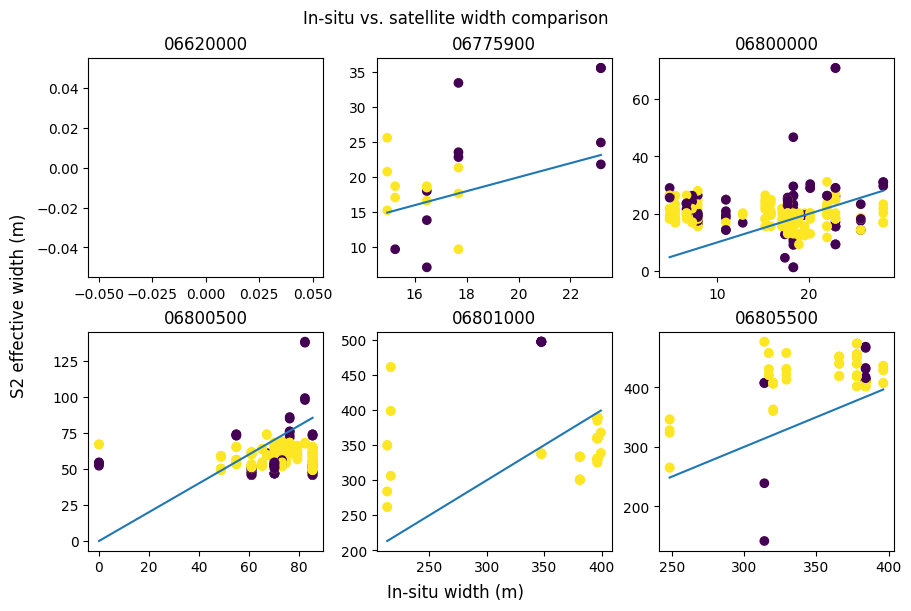

In [248]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9, 6), constrained_layout=True)
p = 0
for g, df in alldata.groupby('site_no'):


    ax = axs.flatten()[p]

    ax.scatter(df.gage_width_m, df.sat_width_m, c=df.like)
    unity = np.linspace(df.gage_width_m.min(), df.gage_width_m.max())
    ax.plot(unity, unity)
    ax.set_title(g)
    p += 1

fig.supxlabel('In-situ width (m)')
fig.supylabel('S2 effective width (m)')
fig.suptitle('In-situ vs. satellite width comparison')

Text(0.5, 0.98, 'S2 width vs gage discharge')

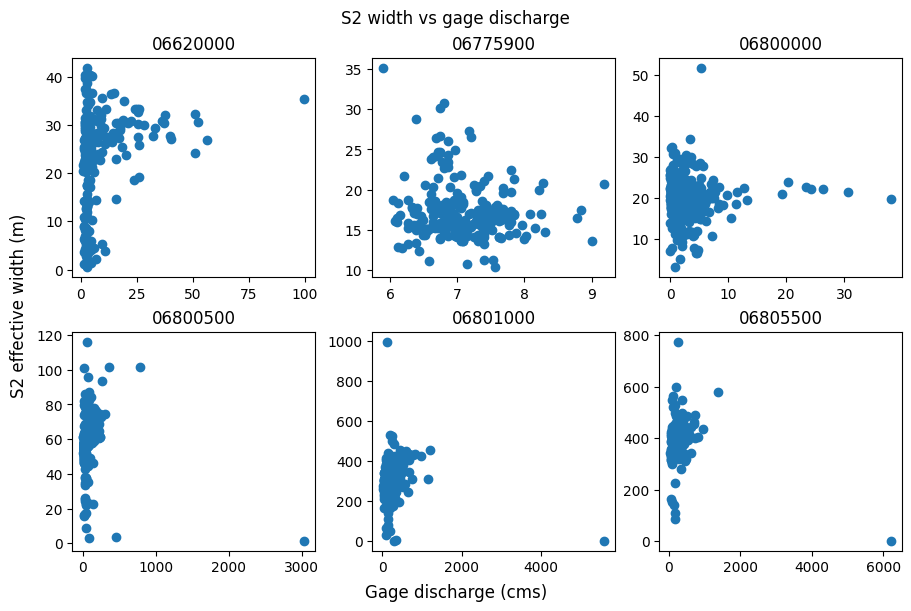

In [277]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9, 6), constrained_layout=True)
p = 0
for g, df in gage_avg_ew.groupby('site_no'):


    ax = axs.flatten()[p]

    ax.scatter(df.Q_cms, df.mean_sat_width_m)

    ax.set_title(g)
    p += 1

fig.supxlabel('Gage discharge (cms)')
fig.supylabel('S2 effective width (m)')
fig.suptitle('S2 width vs gage discharge')

In [ ]:
unity

array([59.13773316, 59.8441198 , 60.55050643, 61.25689307, 61.9632797 ,
       62.66966634, 63.37605297, 64.08243961, 64.78882624, 65.49521288,
       66.20159951, 66.90798615, 67.61437278, 68.32075942, 69.02714605,
       69.73353269, 70.43991932, 71.14630596, 71.85269259, 72.55907923,
       73.26546586, 73.9718525 , 74.67823913, 75.38462577, 76.0910124 ,
       76.79739904, 77.50378567, 78.21017231, 78.91655894, 79.62294558,
       80.32933222, 81.03571885, 81.74210549, 82.44849212, 83.15487876,
       83.86126539, 84.56765203, 85.27403866, 85.9804253 , 86.68681193,
       87.39319857, 88.0995852 , 88.80597184, 89.51235847, 90.21874511,
       90.92513174, 91.63151838, 92.33790501, 93.04429165, 93.75067828])